In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [351]:
spark_generator = NewsHeadlines(#locs=['jp'], #['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\Documents\workspace\nnn\babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
    cats = ['business', 'general'],
    # business, entertainment, general, health, science, sports, technology
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/54 [00:00<?, ?it/s]

In [533]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='Digital Transformation at Khalifa Port: Data-Driven Insights')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 4910911#2494534#91220#1684065#6805333
print(ctx['seed'])
print(ctx['spark'])

4910911
Title: Small plastic bottles now also have a deposit: this is what you need to know - NU.nl
Description: From Tuesday, a 15 cent deposit will be charged on small plastic bottles for soft drinks or water. If you hand it in at the supermarket or other sellers, you will receive a 15 cent deposit back. But the old bottles will remain in circulation for a while. Five questions…
Original Language: Dutch


In [535]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Small plastic bottles now also have a deposit: this is what you need to know - NU.nl
Description: From Tuesday, a 15 cent deposit will be charged on small plastic bottles for soft drinks or water. If you hand it in at the supermarket or other sellers, you will receive a 15 cent deposit back. But the old bottles will remain in circulation for a while. Five questions…
Original Language: Dutch
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You d

In [536]:
##############################################
motivation_raw = '''
{
  "introduction": "With the new policy on small plastic bottles coming into effect, it's interesting to think about how this might change our recycling habits. We could track the number of small bottles returned for a deposit over the next six months at several local supermarkets. This would give us an idea of whether the 15 cent deposit is encouraging more people to recycle and how quickly the old bottles are disappearing from circulation.",
  "title": "Impact_of_Deposit_on_Plastic_Bottle_Recycling"
}

'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [537]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [560]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''
[
  {
    "name": "Increased Recycling Rate",
    "description": "Increase in the number of plastic bottles being recycled",
    "type": "outcome",
    "observed": true,
    "values": ["No increase", "Increase"],
    "parents": ["Recycling Convenience", "Perceived Benefit of Recycling"]
  },
  {
    "name": "Deposit Policy Implementation",
    "description": "Implementation of the 15 cent deposit policy on small plastic bottles",
    "type": "treatment",
    "observed": true,
    "values": ["Not implemented", "Implemented"],
    "parents": ["Environmental Concern", "Economic Incentives Sensitivity"]
  },
  {
    "name": "Public Awareness Campaign",
    "description": "Awareness campaign about the new deposit policy",
    "type": "treatment",
    "observed": true,
    "values": ["No campaign", "Campaign conducted"],
    "parents": ["Environmental Concern", "Economic Incentives Sensitivity"]
  },
  {
    "name": "Environmental Concern",
    "description": "Level of environmental concern in the population",
    "type": "confounder",
    "observed": true,
    "values": ["Low concern", "High concern"],
    "parents": []
  },
  {
    "name": "Economic Incentives Sensitivity",
    "description": "Sensitivity of the population to economic incentives like deposits",
    "type": "confounder",
    "observed": true,
    "values": ["Low sensitivity", "High sensitivity"],
    "parents": []
  },
  {
    "name": "Recycling Convenience",
    "description": "Convenience of recycling for the public",
    "type": "mediator",
    "observed": true,
    "values": ["Inconvenient", "Convenient"],
    "parents": ["Deposit Policy Implementation", "Economic Incentives Sensitivity"]
  },
  {
    "name": "Perceived Benefit of Recycling",
    "description": "Public's perception of the benefits of recycling",
    "type": "mediator",
    "observed": true,
    "values": ["Low perceived benefit", "High perceived benefit"],
    "parents": ["Environmental Concern", "Public Awareness Campaign"]
  },
  {
    "name": "Supermarket Participation",
    "description": "Active participation of supermarkets in the recycling program",
    "type": "collider",
    "observed": true,
    "values": ["Not participating", "Participating"],
    "parents": ["Deposit Policy Implementation", "Recycling Convenience", "Perceived Benefit of Recycling"]
  }
]

'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

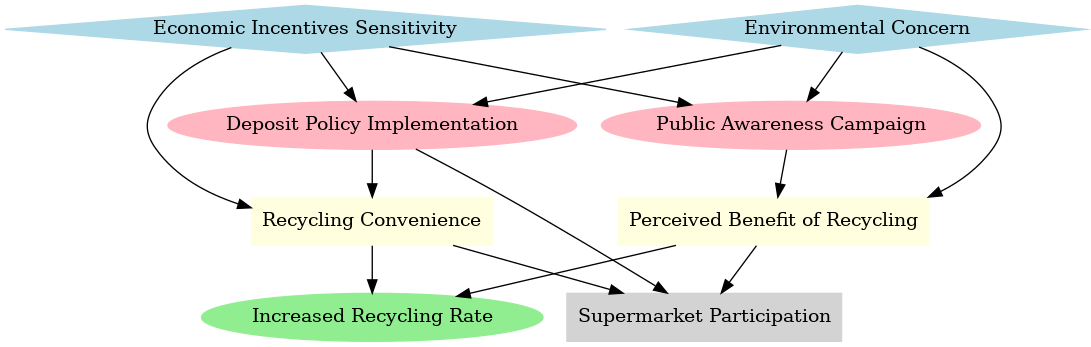

In [561]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [562]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
# print(FileTemplate('structure').fill_in(ctx))
print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

With the new policy on small plastic bottles coming into effect, it's interesting to think about how this might change our recycling habits. We could track the number of small bottles returned for a deposit over the next six months at several local supermarkets. This would give us an idea of whether the 15 cent deposit is encouraging more people to recycle and how quickly the old bottles are disappearing from circulation.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their relationships (including using terms like "affects", "confounder"/"confoundin

In [563]:
#################################################

structure_raw = '''
[
  {"sentence": "Interestingly, the level of environmental concern and sensitivity to economic incentives in the population both play a significant role in influencing the implementation of the new deposit policy on plastic bottles and the effectiveness of public awareness campaigns.", "involved": ["Environmental Concern", "Economic Incentives Sensitivity", "Deposit Policy Implementation", "Public Awareness Campaign"]},
  {"sentence": "The convenience of recycling for the public, which can be swayed by the deposit policy and economic incentives sensitivity, directly impacts the increase in recycling rates of plastic bottles.", "involved": ["Deposit Policy Implementation", "Economic Incentives Sensitivity", "Recycling Convenience", "Increased Recycling Rate"]},
  {"sentence": "Public's perception of the benefits of recycling, shaped by their environmental concern and the presence of awareness campaigns, also contributes to the change in recycling rates.", "involved": ["Environmental Concern", "Public Awareness Campaign", "Perceived Benefit of Recycling", "Increased Recycling Rate"]},
  {"sentence": "Moreover, the supermarkets' active participation in the recycling program is influenced by both the deposit policy implementation and how convenient and beneficial the public perceives recycling to be.", "involved": ["Deposit Policy Implementation", "Recycling Convenience", "Perceived Benefit of Recycling", "Supermarket Participation"]},
  {"sentence": "The active involvement of supermarkets can be seen as a meeting point of policy implementation and public engagement in recycling efforts.", "involved": ["Supermarket Participation", "Deposit Policy Implementation", "Recycling Convenience"]},
  {"sentence": "It's fascinating to see how both environmental concern and economic incentives sensitivity serve as foundational factors affecting almost every other aspect of this recycling initiative.", "involved": ["Environmental Concern", "Economic Incentives Sensitivity"]}
]

'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [564]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

With the new policy on small plastic bottles coming into effect, it's interesting to think about how this might change our recycling habits. We could track the number of small bottles returned for a deposit over the next six months at several local supermarkets. This would give us an idea of whether the 15 cent deposit is encouraging more people to recycle and how quickly the old bottles are disappearing from circulation.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Environmental Concern" is "High concern" (rather than "Low concern")?
2. what is the probability that "Economic Incentives Sensitivity" is "High sensitivity" (rather than "Low sensitivity")?
3. when "Environmental Concern" is "Low concern" and "Economic Incentives Sensitivity" is "Low sensitivity": what i

In [565]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''
{
  "1": [0.4, 0.6],
  "2": [0.3, 0.5],
  "3": [0.1, 0.2],
  "4": [0.4, 0.6],
  "5": [0.6, 0.7],
  "6": [0.7, 0.9],
  "7": [0.1, 0.3],
  "8": [0.5, 0.7],
  "9": [0.6, 0.8],
  "10": [0.8, 0.9],
  "11": [0.3, 0.5],
  "12": [0.4, 0.6],
  "13": [0.6, 0.8],
  "14": [0.7, 0.9],
  "15": [0.2, 0.4],
  "16": [0.5, 0.6],
  "17": [0.6, 0.7],
  "18": [0.8, 0.9],
  "19": [0.1, 0.2],
  "20": [0.3, 0.4],
  "21": [0.5, 0.6],
  "22": [0.7, 0.8],
  "23": [0.2, 0.3],
  "24": [0.3, 0.4],
  "25": [0.4, 0.5],
  "26": [0.5, 0.6],
  "27": [0.3, 0.4],
  "28": [0.4, 0.5],
  "29": [0.6, 0.7],
  "30": [0.7, 0.8]
}

'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [566]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

net = BernoulliNetwork({node['name']: node['parents'] for node in ctx['nodes']})

def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges)) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, outcome, conditions=conditions).item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(20, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

-----------------------------  ---------------  ------------------  ---------------------------------------------------------------------
Deposit Policy Implementation  Not implemented  Implemented         Implementation of the 15 cent deposit policy on small plastic bottles
Public Awareness Campaign      No campaign      Campaign conducted  Awareness campaign about the new deposit policy
Increased Recycling Rate       No increase      Increase            Increase in the number of plastic bottles being recycled
-----------------------------  ---------------  ------------------  ---------------------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Environmental Concern' means Level of environmental concern in the population
'Economic Incentives Sensitivity' means Sensitivity of the population to economic incentives like deposits
'Deposit Policy Implementation' means Implementation of the 15 cent deposit policy on small plastic bottles
'Public Awareness Campaign' means Awareness campaign about the new deposit policy
'Recycling Convenience' means Convenience of recycling for the public
'Perceived Benefit of Recycling' means Public's perception of the benefits of recycling
'Increased Recycling Rate' means Increase in the number of plastic bottles being recycled
'Supermarket Participation' means Active participation of supermarkets in the recycling program
Treatment Value     Treatment                      Outcome Value    Outcome                         ATE    Correlation
------------------  -----------------------------  ---------------  ------------------------  ---------  -------------
Implemented         Deposit Policy Impleme

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


Treatment                                                ATE    Correlation  Outcome
-----------------------------------------------------  -----  -------------  -----------------------------------------------------
High concern Environmental Concern                      0              0     High sensitivity Economic Incentives Sensitivity
High concern Environmental Concern                      0.4            0.4   Implemented Deposit Policy Implementation
High concern Environmental Concern                      0.39           0.39  Campaign conducted Public Awareness Campaign
High concern Environmental Concern                      0.15           0.14  Convenient Recycling Convenience
High concern Environmental Concern                      0.38           0.37  High perceived benefit Perceived Benefit of Recycling
High concern Environmental Concern                      0.14           0.13  Increase Increased Recycling Rate
High concern Environmental Concern                      0.12     

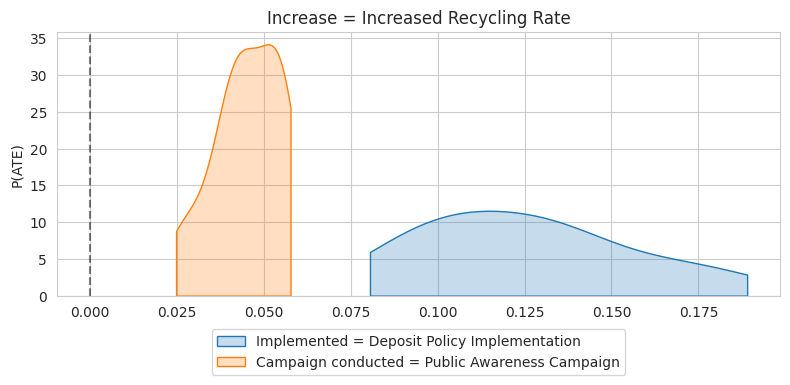

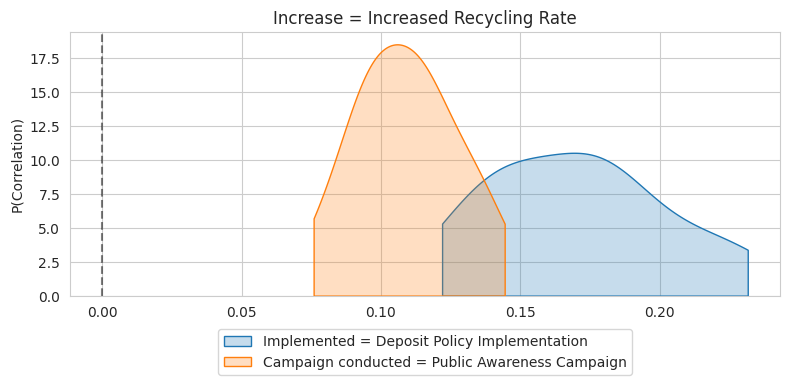

In [567]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
# assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
# assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'], node2['name']).item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

# print(net.backdoor_estimand(treatment1['name'], outcome['name']))
# print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [568]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(FileTemplate('verbs').fill_in(ctx))
# print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Environmental Concern' (0='Low concern', 1='High concern') means Level of environmental concern in the population
Variable 'Economic Incentives Sensitivity' (0='Low sensitivity', 1='High sensitivity') means Sensitivity of the populati

In [569]:
# verbalization = ctx['verbs']
#################################################
verbalization_raw = '''
{
  "Environmental Concern": {
    "descriptor": ["the level of environmental concern", "environmental awareness"],
    "subject": "the public",
    "predicate0": ["is not very concerned about the environment", "shows low environmental concern"],
    "predicate1": ["is highly concerned about the environment", "displays significant environmental concern"],
    "pronoun": "they",
    "nounclause0": ["the public is not very concerned about the environment", "there is low environmental concern among the population"],
    "nounclause1": ["the public is highly concerned about the environment", "there is significant environmental concern among the population"],
    "preposition": ["among", "within"],
    "domain": "the population",
    "subclause0": ["environmental concern is low", "there is a lack of concern for the environment"],
    "subclause1": ["environmental concern is high", "there is a strong concern for the environment"],
    "condition0": ["if environmental awareness is low", "when the public shows little concern for the environment"],
    "condition1": ["if environmental awareness is high", "when the public is highly concerned about the environment"],
    "action0": ["environmental concern decreases", "the public becomes less concerned about the environment"],
    "action1": ["environmental concern increases", "the public becomes more concerned about the environment"]
  },
  "Economic Incentives Sensitivity": {
    "descriptor": ["sensitivity to economic incentives", "response to financial motivators"],
    "subject": "people",
    "predicate0": ["are less responsive to economic incentives", "show low sensitivity to financial motivators"],
    "predicate1": ["are highly responsive to economic incentives", "show high sensitivity to financial motivators"],
    "pronoun": "they",
    "nounclause0": ["people are less responsive to economic incentives", "there is low sensitivity to financial motivators"],
    "nounclause1": ["people are highly responsive to economic incentives", "there is high sensitivity to financial motivators"],
    "preposition": ["among", "in"],
    "domain": "the population",
    "subclause0": ["sensitivity to economic incentives is low", "there is little response to financial motivators"],
    "subclause1": ["sensitivity to economic incentives is high", "there is a strong response to financial motivators"],
    "condition0": ["if the response to financial motivators is low", "when people are less influenced by economic incentives"],
    "condition1": ["if the response to financial motivators is high", "when people are strongly influenced by economic incentives"],
    "action0": ["economic incentives become less effective", "people become less responsive to financial motivators"],
    "action1": ["economic incentives become more effective", "people become more responsive to financial motivators"]
  },
  "Deposit Policy Implementation": {
    "descriptor": ["the implementation of the deposit policy", "the enactment of the bottle deposit scheme"],
    "subject": "the policy",
    "predicate0": ["has not been implemented", "is not in effect"],
    "predicate1": ["has been implemented", "is in effect"],
    "pronoun": "it",
    "nounclause0": ["the deposit policy has not been implemented", "the bottle deposit scheme is not in effect"],
    "nounclause1": ["the deposit policy has been implemented", "the bottle deposit scheme is in effect"],
    "preposition": ["under", "with"],
    "domain": "the new regulation",
    "subclause0": ["the deposit policy is not active", "there is no implementation of the bottle deposit scheme"],
    "subclause1": ["the deposit policy is active", "the bottle deposit scheme is implemented"],
    "condition0": ["if the deposit policy is not implemented", "when the bottle deposit scheme is not in effect"],
    "condition1": ["if the deposit policy is implemented", "when the bottle deposit scheme is in effect"],
    "action0": ["the deposit policy is not put into action", "the bottle deposit scheme is not enacted"],
    "action1": ["the deposit policy is put into action", "the bottle deposit scheme is enacted"]
  },
  "Public Awareness Campaign": {
    "descriptor": ["the presence of a public awareness campaign", "the conduct of an informational campaign"],
    "subject": "the campaign",
    "predicate0": ["is not conducted", "is absent"],
    "predicate1": ["is conducted", "is active"],
    "pronoun": "it",
    "nounclause0": ["a public awareness campaign is not conducted", "there is no informational campaign"],
    "nounclause1": ["a public awareness campaign is conducted", "there is an active informational campaign"],
    "preposition": ["without", "with"],
    "domain": "the initiative",
    "subclause0": ["there is an absence of an awareness campaign", "no campaign is being conducted"],
    "subclause1": ["there is an active awareness campaign", "a campaign is being conducted"],
    "condition0": ["if there is no public awareness campaign", "when an informational campaign is not conducted"],
    "condition1": ["if there is a public awareness campaign", "when an informational campaign is conducted"],
    "action0": ["a public awareness campaign is not launched", "no informational campaign is conducted"],
    "action1": ["a public awareness campaign is launched", "an informational campaign is conducted"]
  },
  "Recycling Convenience": {
    "descriptor": ["the convenience of recycling", "the ease of recycling"],
    "subject": "recycling",
    "predicate0": ["is inconvenient", "is not easy"],
    "predicate1": ["is convenient", "is easy"],
    "pronoun": "it",
    "nounclause0": ["recycling is inconvenient", "it is not easy to recycle"],
    "nounclause1": ["recycling is convenient", "it is easy to recycle"],
    "preposition": ["in", "with"],
    "domain": "the system",
    "subclause0": ["recycling is a difficult process", "there is a lack of convenience in recycling"],
    "subclause1": ["recycling is a simple process", "there is ease of access in recycling"],
    "condition0": ["if recycling is inconvenient", "when it is not easy to recycle"],
    "condition1": ["if recycling is convenient", "when it is easy to recycle"],
    "action0": ["recycling is made more difficult", "the convenience of recycling is not prioritized"],
    "action1": ["recycling is made easier", "the convenience of recycling is prioritized"]
  },
  "Perceived Benefit of Recycling": {
    "descriptor": ["the perceived benefit of recycling", "how recycling is viewed in terms of benefits"],
    "subject": "the public",
    "predicate0": ["sees little benefit in recycling", "perceives low benefits from recycling"],
    "predicate1": ["sees significant benefits in recycling", "perceives high benefits from recycling"],
    "pronoun": "they",
    "nounclause0": ["the public sees little benefit in recycling", "there is a low perception of benefits from recycling"],
    "nounclause1": ["the public sees significant benefits in recycling", "there is a high perception of benefits from recycling"],
    "preposition": ["among", "in"],
    "domain": "the population",
    "subclause0": ["the benefits of recycling are viewed as minimal", "there is a low perceived value in recycling"],
    "subclause1": ["the benefits of recycling are viewed as substantial", "there is a high perceived value in recycling"],
    "condition0": ["if the benefits of recycling are perceived as low", "when there is little perceived value in recycling"],
    "condition1": ["if the benefits of recycling are perceived as high", "when there is significant perceived value in recycling"],
    "action0": ["the perceived benefits of recycling decrease", "recycling is viewed as less beneficial"],
    "action1": ["the perceived benefits of recycling increase", "recycling is viewed as more beneficial"]
  },
  "Increased Recycling Rate": {
    "descriptor": ["the recycling rate of plastic bottles", "the rate of plastic bottle recycling"],
    "subject": "recycling centers",
    "predicate0": ["are not seeing more returned bottles", "haven't reported an increase in returned bottles"],
    "predicate1": ["are seeing more returned bottles", "have reported an increase in returned bottles"],
    "pronoun": "they",
    "nounclause0": ["there isn't an increase in the number of plastic bottles being recycled", "the recycling rate for plastic bottles remains the same"],
    "nounclause1": ["there is an increase in the number of plastic bottles being recycled", "the recycling rate for plastic bottles has gone up"],
    "preposition": ["among", "within"],
    "domain": ["recycling centers", "the community"],
    "subclause0": ["recycling centers aren't handling more plastic bottles", "the community hasn't upped its recycling efforts"],
    "subclause1": ["recycling centers are handling more plastic bottles", "the community has upped its recycling efforts"],
    "condition0": ["If the number of recycled plastic bottles remains the same", "When there's no change in recycling habits"],
    "condition1": ["If there's an uptick in recycled plastic bottles", "When more people start recycling plastic bottles"],
    "action0": ["recycling habits stay the same", "people don't change their recycling behavior"],
    "action1": ["recycling habits improve", "more people start recycling"]
  },
  "Supermarket Participation": {
    "descriptor": ["supermarket involvement in recycling", "participation of supermarkets in the recycling program"],
    "subject": "supermarkets",
    "predicate0": ["are not part of the recycling program", "haven't joined the recycling effort"],
    "predicate1": ["are actively involved in the recycling program", "have joined the recycling effort"],
    "pronoun": "they",
    "nounclause0": ["supermarkets are not participating in the recycling program", "there is no active participation from supermarkets in recycling"],
    "nounclause1": ["supermarkets are participating in the recycling program", "there is active participation from supermarkets in recycling"],
    "preposition": ["in", "among"],
    "domain": ["local supermarkets", "the retail sector"],
    "subclause0": ["a supermarket stays out of the recycling program", "there's no recycling initiative in the supermarket"],
    "subclause1": ["a supermarket takes an active role in the recycling program", "there's a visible recycling initiative in the supermarket"],
    "condition0": ["If supermarkets don't join the recycling program", "When supermarkets are not involved in recycling"],
    "condition1": ["If supermarkets take part in the recycling program", "When supermarkets actively engage in recycling"],
    "action0": ["supermarkets remain uninvolved in recycling", "supermarkets don't participate in recycling initiatives"],
    "action1": ["supermarkets start participating in recycling", "supermarkets launch recycling initiatives"]
  }
}
'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)

In [570]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

With the new policy on small plastic bottles coming into effect, it's interesting to think about how this might change our recycling habits. We could track the number of small bottles returned for a deposit over the next six months at several local supermarkets. This would give us an idea of whether the 15 cent deposit is encouraging more people to recycle and how quickly the old bottles are disappearing from circulation.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('Deposit Policy Implementation') < 0
	2. ATE('Public Awareness Campaign') < 0
	3. ATE('Deposit Policy Implementation') < ATE('Public Awareness Campaign')
	4. |ATE('Deposit Policy Implementation')| < |ATE('Public Awareness Campaign')|
	5. CATE('Deposit Policy Implementation' | 'Environm

In [571]:
# setting = ctx['questions']
#################################################
settings_raw = '''
{
    "1": {
        "question": "Is the implementation of the 15 cent deposit policy on small plastic bottles not increasing the recycling rate?",
        "answer": "yes",
        "claim": "The implementation of the 15 cent deposit policy on small plastic bottles does not lead to an increase in the recycling rate."
    },
    "2": {
        "question": "Is conducting a public awareness campaign about the new deposit policy not increasing the recycling rate?",
        "answer": "yes",
        "claim": "Conducting a public awareness campaign about the new deposit policy does not result in an increase in the recycling rate."
    },
    "3": {
        "question": "Is the impact of the deposit policy on increasing recycling rates less than that of the public awareness campaign?",
        "answer": "yes",
        "claim": "The deposit policy's impact on increasing recycling rates is less compared to the public awareness campaign."
    },
    "4": {
        "question": "Is the absolute impact of the deposit policy on recycling rates smaller than that of the public awareness campaign?",
        "answer": "yes",
        "claim": "The absolute effect of the deposit policy on recycling rates is smaller than that of the public awareness campaign."
    },
    "5": {
        "question": "In the context of low environmental concern, does implementing the deposit policy increase the recycling rate?",
        "answer": "yes",
        "claim": "Even with low environmental concern in the population, implementing the deposit policy leads to an increase in recycling rates."
    },
    "6": {
        "question": "In the context of low environmental concern, does conducting a public awareness campaign decrease the recycling rate?",
        "answer": "yes",
        "claim": "When environmental concern is low, conducting a public awareness campaign actually decreases the recycling rate."
    },
    "7": {
        "question": "In the context of low environmental concern, is the impact of the deposit policy on recycling rates greater than that of the public awareness campaign?",
        "answer": "yes",
        "claim": "With low environmental concern, the deposit policy has a greater impact on increasing recycling rates than the public awareness campaign."
    },
    "8": {
        "question": "In the context of low environmental concern, is the absolute impact of the deposit policy on recycling rates greater than that of the public awareness campaign?",
        "answer": "yes",
        "claim": "When environmental concern is low, the absolute effect of the deposit policy on recycling rates is greater than that of the public awareness campaign."
    },
    "9": {
        "question": "In the context of high environmental concern, does implementing the deposit policy decrease the recycling rate?",
        "answer": "yes",
        "claim": "When environmental concern is high, implementing the deposit policy leads to a decrease in recycling rates."
    },
    "10": {
        "question": "In the context of high environmental concern, does conducting a public awareness campaign increase the recycling rate?",
        "answer": "yes",
        "claim": "With high environmental concern, conducting a public awareness campaign increases the recycling rate."
    },
    "11": {
        "question": "In the context of high environmental concern, is the impact of the public awareness campaign on recycling rates less than that of the deposit policy?",
        "answer": "yes",
        "claim": "In a high environmental concern setting, the deposit policy has a greater impact on recycling rates compared to the public awareness campaign."
    },
    "12": {
        "question": "In the context of high environmental concern, is the absolute impact of the deposit policy on recycling rates greater than that of the public awareness campaign?",
        "answer": "yes",
        "claim": "When environmental concern is high, the absolute effect of the deposit policy on recycling rates is greater than that of the public awareness campaign."
    },
    "13": {
        "question": "Does the deposit policy have a greater positive impact on recycling rates in the context of high environmental concern compared to low concern?",
        "answer": "yes",
        "claim": "The deposit policy is more effective in increasing recycling rates when environmental concern is high than when it is low."
    },
    "14": {
        "question": "Is the absolute impact of the deposit policy on recycling rates smaller in the context of high environmental concern compared to low concern?",
        "answer": "yes",
        "claim": "The absolute effect of the deposit policy on recycling rates is smaller in a high environmental concern context than in a low concern context."
    },
    "15": {
        "question": "Does a public awareness campaign have a greater positive impact on recycling rates in the context of high environmental concern compared to low concern?",
        "answer": "yes",
        "claim": "A public awareness campaign is more effective in increasing recycling rates when environmental concern is high than when it is low."
    },
    "16": {
        "question": "Is the absolute impact of a public awareness campaign on recycling rates smaller in the context of high environmental concern compared to low concern?",
        "answer": "yes",
        "claim": "The absolute effect of a public awareness campaign on recycling rates is smaller in a high environmental concern context than in a low concern context."
    },
    "17": {
        "question": "In the context of low economic incentives sensitivity, does implementing the deposit policy increase the recycling rate?",
        "answer": "yes",
        "claim": "Even with low sensitivity to economic incentives, implementing the deposit policy leads to an increase in recycling rates."
    },
    "18": {
        "question": "In the context of low economic incentives sensitivity, does conducting a public awareness campaign decrease the recycling rate?",
        "answer": "yes",
        "claim": "When the population is less sensitive to economic incentives, conducting a public awareness campaign decreases the recycling rate."
    },
    "19": {
        "question": "In the context of low economic incentives sensitivity, is the impact of the public awareness campaign on recycling rates less than that of the deposit policy?",
        "answer": "yes",
        "claim": "With low economic incentives sensitivity, the deposit policy has a greater impact on recycling rates than the public awareness campaign."
    },
    "20": {
        "question": "In the context of low economic incentives sensitivity, is the absolute impact of the public awareness campaign on recycling rates greater than that of the deposit policy?",
        "answer": "yes",
        "claim": "When economic incentives sensitivity is low, the absolute effect of the public awareness campaign on recycling rates is greater than that of the deposit policy."
    },
    "21": {
        "question": "In the context of high economic incentives sensitivity, does implementing the deposit policy increase the recycling rate?",
        "answer": "yes",
        "claim": "With high sensitivity to economic incentives, implementing the deposit policy leads to an increase in recycling rates."
    },
    "22": {
        "question": "In the context of high economic incentives sensitivity, does conducting a public awareness campaign increase the recycling rate?",
        "answer": "yes",
        "claim": "When the population is highly sensitive to economic incentives, conducting a public awareness campaign increases the recycling rate."
    },
    "23": {
        "question": "In the context of high economic incentives sensitivity, is the impact of the deposit policy on recycling rates less than that of the public awareness campaign?",
        "answer": "yes",
        "claim": "In a high economic incentives sensitivity setting, the public awareness campaign has a greater impact on recycling rates than the deposit policy."
    },
    "24": {
        "question": "In the context of high economic incentives sensitivity, is the absolute impact of the public awareness campaign on recycling rates greater than that of the deposit policy?",
        "answer": "yes",
        "claim": "When economic incentives sensitivity is high, the absolute effect of the public awareness campaign on recycling rates is greater than that of the deposit policy."
    },
    "25": {
        "question": "Does the deposit policy have a greater positive impact on recycling rates in the context of high economic incentives sensitivity compared to low sensitivity?",
        "answer": "yes",
        "claim": "The deposit policy is more effective in increasing recycling rates when economic incentives sensitivity is high than when it is low."
    },
    "26": {
        "question": "Is the absolute impact of the deposit policy on recycling rates smaller in the context of high economic incentives sensitivity compared to low sensitivity?",
        "answer": "yes",
        "claim": "The absolute effect of the deposit policy on recycling rates is smaller in a high economic incentives sensitivity context than in a low sensitivity context."
    },
    "27": {
        "question": "Does a public awareness campaign have a greater positive impact on recycling rates in the context of high economic incentives sensitivity compared to low sensitivity?",
        "answer": "yes",
        "claim": "A public awareness campaign is more effective in increasing recycling rates when economic incentives sensitivity is high than when it is low."
    },
    "28": {
        "question": "Is the absolute impact of a public awareness campaign on recycling rates smaller in the context of high economic incentives sensitivity compared to low sensitivity?",
        "answer": "yes",
        "claim": "The absolute effect of a public awareness campaign on recycling rates is smaller in a high economic incentives sensitivity context than in a low sensitivity context."
    }
}

'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [572]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

'Impact_of_Deposit_on_Plastic_Bottle_Recycling.json'